## Polar Sea Ice Prediction

In [40]:
from numpy.random import seed
seed(1)

In [41]:
#pip install attention

## Initial Setup

In [42]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from attention import Attention
from keras.layers import Dense, Dropout
from keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint


## Loading Combined Data 1979- 2018

Features:
'wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sosaline', 'sst', 't2m', 'surface_pressure','sea_ice_extent'




In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('anommolus_area_by_date.txt', delimiter='\t')


data = data[['Date', 'Anomoulous melting area']]
print(data)


import torch

device = None
if torch.backends.mps.is_available():
    device = torch.device("mps")

print(device)


from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Anomoulous melting area(t-{i})'] = df['Anomoulous melting area'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
print(shifted_df)


shifted_df_as_np = shifted_df.to_numpy()

print(shifted_df_as_np)




from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

print(shifted_df_as_np)


X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

print(X.shape, y.shape)


X = dc(np.flip(X, axis=1))
print(X.shape)

          Date  Anomoulous melting area
0     20000102                     1354
1     20000103                     1346
2     20000104                      750
3     20000105                     1768
4     20000106                      921
...        ...                      ...
8373  20221227                      694
8374  20221228                      847
8375  20221229                     1345
8376  20221230                      808
8377  20221231                      479

[8378 rows x 2 columns]
mps
          Anomoulous melting area  Anomoulous melting area(t-1)  \
Date                                                              
20000109                      907                        1443.0   
20000110                      899                         907.0   
20000111                      643                         899.0   
20000112                     1020                         643.0   
20000113                      778                        1020.0   
...                   

### Adding a Lag to Y values
Here lag = 1 month


In [44]:
#Adding a lag to monthly targets
lag = 1
data = np.expand_dims(X, axis=1)
target = y

print(data.shape)
print(target.shape)


(8371, 1, 7)
(8371,)


## Train Validation Split

LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. We load the csv file and only retain the feature and target columns. The features and target are stored in separate np arrays.

In [45]:

# Sequential split train:val data in 80:20 sequentially 

LEN_DATA = len(data) #total number of pixels

NUM_TRAIN = int(len(data)*0.70)

x_train = data[0:NUM_TRAIN]
x_valid = data[NUM_TRAIN:]

#split features and labels
y_train=target[:NUM_TRAIN] #target is last column i-e sea-ice
y_valid=target[NUM_TRAIN:] #target is last column i-e sea-ice


In [46]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_valid.shape:',x_valid.shape)
print('y_valid.shape:',y_valid.shape)

x_train.shape: (5859, 1, 7)
y_train.shape: (5859,)
x_valid.shape: (2512, 1, 7)
y_valid.shape: (2512,)


## Reshaping Input and Target Features

In [47]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Normalization


In [48]:
# normalize the features


reshaping_size = 7
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,reshaping_size)) #reshaping to 2d for standard scaling
x_valid = scaler_f.transform(x_valid.reshape(-1,reshaping_size)) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_valid = scaler_l.transform(y_valid.reshape(-1,1)) #reshaping to 2d for standard scaling


In [49]:
#Reshaping data to 3D for modeling
timesteps = 1
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_valid = reshape_features(x_valid, timesteps) # reshaping to 3d for model


(5859, 7)
(2512, 7)


In [50]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_valid.shape:',x_valid.shape)
print('y_valid.shape:',y_valid.shape)

x_train.shape: (5859, 1, 7)
y_train.shape: (5859, 1)
x_valid.shape: (2512, 1, 7)
y_valid.shape: (2512, 1)


## LSTM Network

In [51]:
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

timestep = timesteps
features = 7

model_input = Input(shape=(timestep,features))
x = LSTM(64, return_sequences=True)(model_input)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x)
x = Attention(trainable = True)(x)
x = Dropout(0.2)(x)
x = Dense(32)(x)
x = Dense(16)(x)
x = Dense(1)(x)
model = Model(model_input, x)
#model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 64)             18432     
                                                                 
 dropout_4 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_9 (LSTM)               (None, 1, 32)             12416     
                                                                 
 lstm_10 (LSTM)              (None, 1, 16)             3136      
                                                                 
 lstm_11 (LSTM)              (None, 1, 16)             2112      
                                                                 
 attention_2 (Attention)     (None, 128)               4352

In [52]:
extent = target
print(extent.shape)

(8371,)


## Compiling the Network and Fitting Model

In [53]:
#Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


In [54]:
history=model.fit(x_train, y_train, epochs=500, batch_size=12, verbose=2, validation_split =0.3, shuffle=True,callbacks=keras_callbacks)

Epoch 1/500


2023-10-30 10:26:42.473824: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-30 10:26:44.682602: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size:

342/342 - 4s - loss: 0.4962 - val_loss: 0.3834 - 4s/epoch - 12ms/step
Epoch 2/500


/Users/maloyd1/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


342/342 - 1s - loss: 0.4214 - val_loss: 0.3872 - 847ms/epoch - 2ms/step
Epoch 3/500
342/342 - 1s - loss: 0.4245 - val_loss: 0.3932 - 965ms/epoch - 3ms/step
Epoch 4/500
342/342 - 1s - loss: 0.4223 - val_loss: 0.3869 - 941ms/epoch - 3ms/step
Epoch 5/500
342/342 - 1s - loss: 0.4180 - val_loss: 0.3988 - 917ms/epoch - 3ms/step
Epoch 6/500
342/342 - 1s - loss: 0.4213 - val_loss: 0.3884 - 865ms/epoch - 3ms/step
Epoch 7/500
342/342 - 1s - loss: 0.4216 - val_loss: 0.4047 - 855ms/epoch - 2ms/step
Epoch 8/500
342/342 - 1s - loss: 0.4136 - val_loss: 0.3899 - 857ms/epoch - 3ms/step
Epoch 9/500
342/342 - 1s - loss: 0.4156 - val_loss: 0.3811 - 841ms/epoch - 2ms/step
Epoch 10/500
342/342 - 1s - loss: 0.4145 - val_loss: 0.3932 - 885ms/epoch - 3ms/step
Epoch 11/500
342/342 - 1s - loss: 0.4169 - val_loss: 0.3859 - 833ms/epoch - 2ms/step
Epoch 12/500
342/342 - 1s - loss: 0.4193 - val_loss: 0.4217 - 872ms/epoch - 3ms/step
Epoch 13/500
342/342 - 1s - loss: 0.4120 - val_loss: 0.3835 - 951ms/epoch - 3ms/step


## Model Predictions

In [55]:
trainPred = model.predict(x_train)
testPred = model.predict(x_valid)

  1/184 [..............................] - ETA: 1:35

2023-10-30 10:27:44.260484: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


79/79 [==============================] - 0s 731us/step


In [56]:
print(testPred.shape)
print(trainPred.shape)

(2512, 1)
(5859, 1)


In [57]:
#Reverting data back to 2D from 3D
x_valid_t = x_valid.reshape((x_valid.shape[0], x_valid.shape[2]))
print(x_valid_t.shape)
print(testPred.shape)

(2512, 7)
(2512, 1)


In [58]:
# invert scaling for forecasted values 

inv_testPred = scaler_l.inverse_transform(testPred)
print(inv_testPred[1])

# invert scaling for actual values

inv_y_valid = scaler_l.inverse_transform(y_valid)
print(inv_y_valid[1])


[-0.8419391]
[-0.92838428]


In [59]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(inv_y_valid, inv_testPred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.154


In [60]:
# calculate Normalized RMSE
y_max = inv_y_valid.max()
y_min = inv_y_valid.min()
nrmse = rmse /(inv_y_valid.mean()) 
print('Test NRMSE:', nrmse)

Test NRMSE: -0.2542625714997195


In [61]:
# calculate R-square
from sklearn.metrics import r2_score
from math import sqrt

r_sq = r2_score(inv_y_valid, inv_testPred)
print('Test R_Square: %.3f' % r_sq)

Test R_Square: 0.565


## Plotting

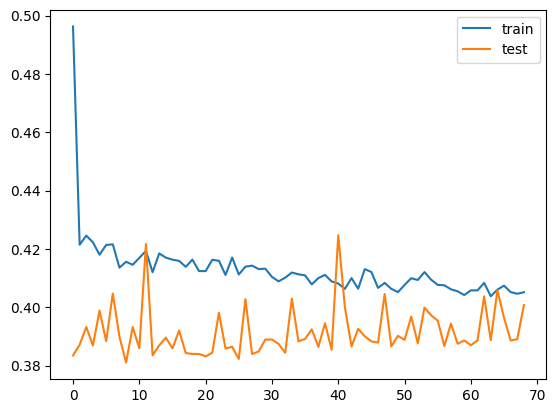

In [62]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


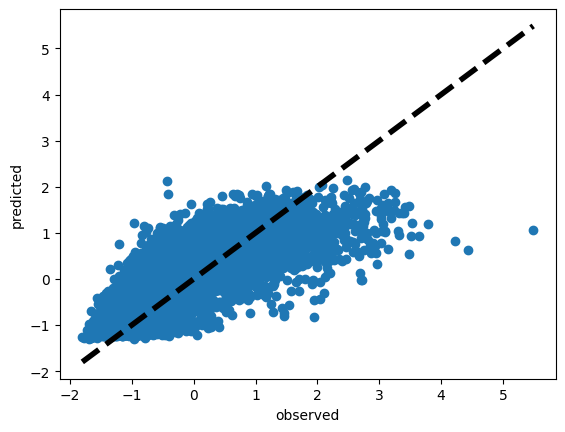

In [63]:
fig, ax = plt.subplots()
ax.scatter(y_train,trainPred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()


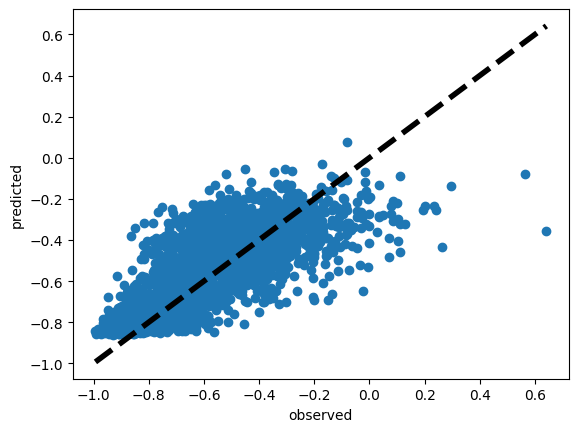

In [64]:
fig, ax = plt.subplots()
ax.scatter(inv_y_valid,inv_testPred) #[:,:,6]
ax.plot([inv_y_valid.min(), inv_y_valid.max()], [inv_y_valid.min(), inv_y_valid.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
#plt.savefig('test_prediction.png',bbox_inches='tight',dpi=1200)
plt.show()

In [65]:
trainPred = np.transpose(trainPred.flatten())

print(trainPred.shape)
print(y_train.shape)

(5859,)
(5859, 1)


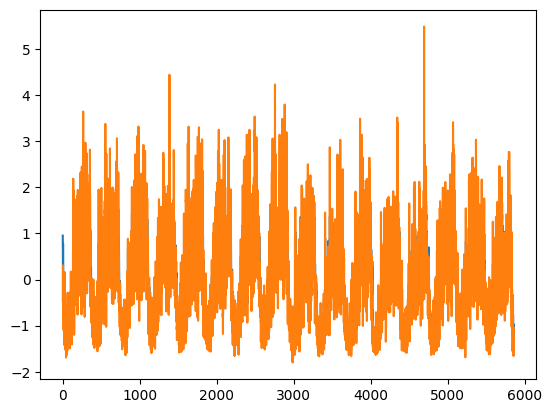

In [66]:
from matplotlib import pyplot

pyplot.plot(trainPred)
pyplot.plot(y_train)
pyplot.show()

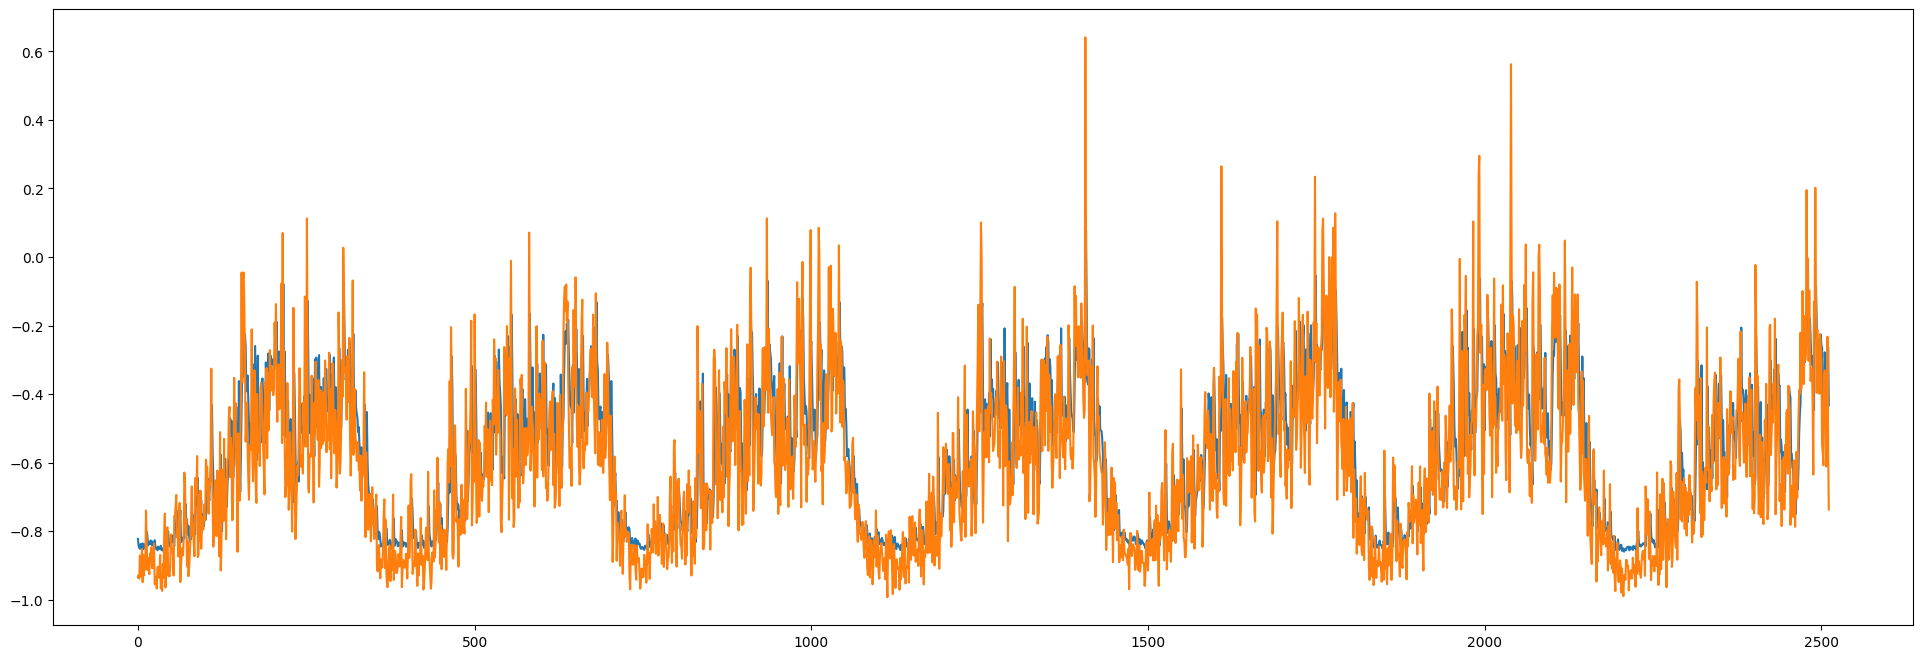

In [67]:
from matplotlib import pyplot
fig, ax= plt.subplots(figsize=(24, 8))
pyplot.plot(inv_testPred)
pyplot.plot(inv_y_valid)
pyplot.show()